In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
mskBarents = mskBasin[mskBasin == 6]

In [9]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

In [6]:
# define the years of this that we want to read from
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2006"] = np.array([12])
times["2007"] = np.arange(1,4,1)


# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps # this is 3 for the 3 months we want to do the budget from

3

In [7]:
# define the years of this that we want to read from
fnames = get_fnames(dt_aste,startyr,endyr)

times2 = {}
times2["2013"] = np.array([12])
times2["2014"] = np.arange(1,4,1)


# the filenames we want for 2014
tsstr2,datetimes2 = get_tsteps(times2,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt2 = datetimes2[1]-datetimes2[0]   # days
dt2 = dt2.total_seconds()

tsteps2 = len(datetimes2)-1
tsteps2 # this is 3 for the 3 months we want to do the budget from

3

In [8]:
# load the SST for the two years

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
THETA = np.zeros((len(tsstr[:-1])+len(tsstr2[:-1]),nz,ny,nx))

#DJF 2007
for t in range(len(tsstr[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t] = THETAi

#DJF 2016
for t in range(len(tsstr2[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr2[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t+3] = THETAi

# do the time averaging
THETA1 = np.nanmean(THETA[:3],axis=0) #* hfC
THETA2 = np.nanmean(THETA[3:],axis=0) #* hfC

# define the indices of the transect

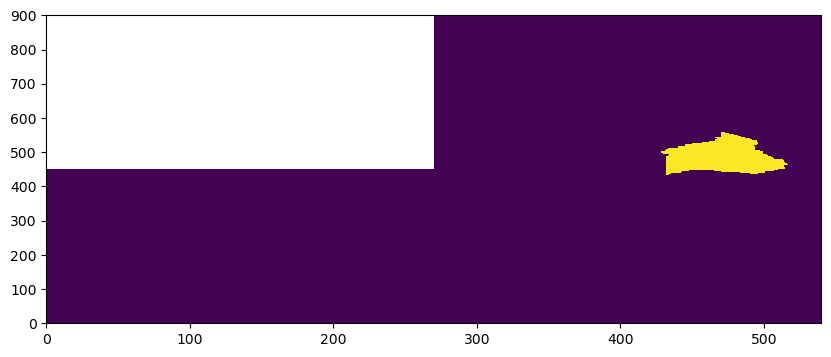

In [10]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

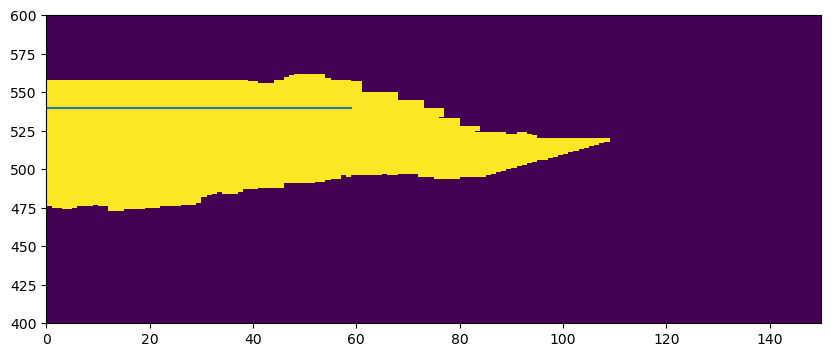

In [43]:
plt.pcolormesh(mymsk)
plt.xlim(0,150)
plt.ylim(400,600)
x_pf = np.arange(0,60,1)
y_pf = np.full(x.shape[0],540)
plt.plot(x_pf,y_pf)

# get the temperature profile with depth at this slice (similar to gate)

In [39]:
# get the theta profile average for this sectino
# get the theta and salt for all years

allTHETA = np.full((4,12,nz,ny,nx),np.nan)
allSALT = np.full((4,12,nz,ny,nx),np.nan)

thetaprofile = np.zeros((nz,4*12))

iy = 0
it = 0
yrs = np.array([2006,2007,2013,2014])
# yrs = np.array([2005,2006,2012,2013])  # lead time of 1 year

for year in yrs:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    THETA_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALT_all = np.full((len(tsstr),nz,ny,nx),np.nan)

    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    
        THETA_all[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx))
        SALT_all[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx))

        
    # set this in the larger array
    allTHETA[iy,:,:,:,:] = THETA_all
    allSALT[iy,:,:,:,:] = SALT_all

    
    iy += 1

2006
2007
2013
2014


In [40]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_pf,x_pf)

In [41]:
# do a sample for the BSO
# get the distance from coast to coast from DXG and DYG
distance = np.array([])

# get the adv values
for i in range(len(x)):
    thisy = y_pf[i]
    thisx = x_pf[i]
    this_choose = choose_UV_bso[i]


    if this_choose == 'H':
        distance = np.append(distance,(mygrid['DYG'][thisy,thisx]))
    else:
        distance = np.append(distance,(mygrid['DXG'][thisy,thisx]))

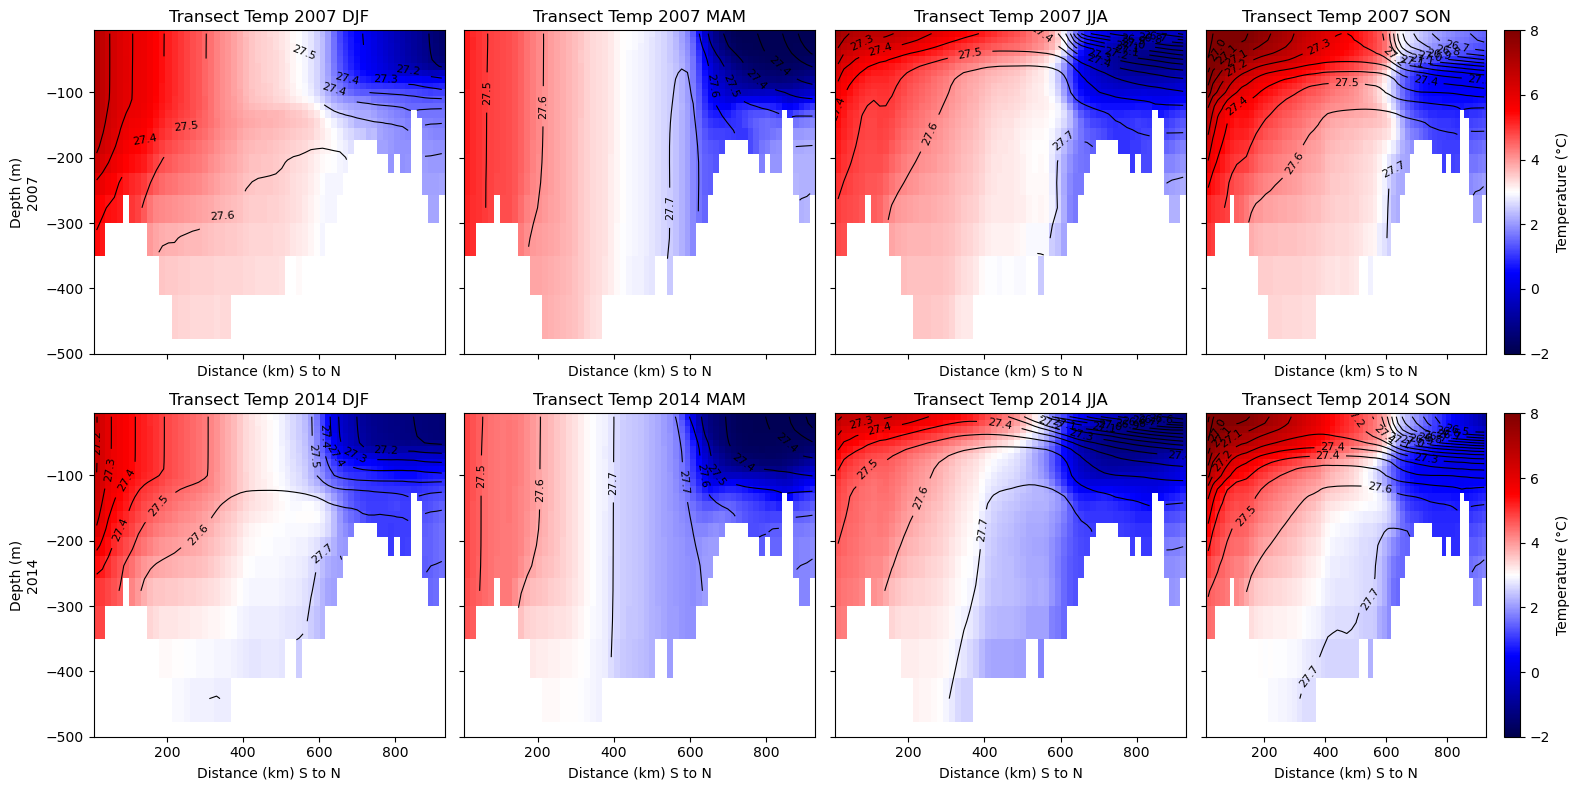

In [58]:
# **Define seasons (with DJF using December from the previous year)**
seasons = {
    "DJF": {"prev_dec": True, "months": [0, 1]},  # December (prev year) + Jan, Feb
    "MAM": {"prev_dec": False, "months": [2, 3, 4]},  # Mar, Apr, May
    "JJA": {"prev_dec": False, "months": [5, 6, 7]},  # Jun, Jul, Aug
    "SON": {"prev_dec": False, "months": [8, 9, 10]}  # Sep, Oct, Nov
}

# **Set distance and depth axes**
x = np.cumsum(distance / 1000)  # Convert to km
y = np.cumsum(-mygrid["DRF"])  # Depth in meters

# **Define the years we are comparing**
# yrs = np.array([2006,2007,2013,2014])
year_pairs = [(2006, 2007), (2013, 2014)]  # (Previous year for DJF, main year)


# **Create figure and subplots (2 rows: years, 4 columns: seasons)**
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)

for row_idx, (prev_year, main_year) in enumerate(year_pairs):  # Compare 2007 vs. 2014
    for col_idx, (season, config) in enumerate(seasons.items()):
        # Identify indices for selected years
        prev_year_idx = np.where(yrs == prev_year)[0][0]
        main_year_idx = np.where(yrs == main_year)[0][0]

        # **Handle DJF separately**
        if config["prev_dec"]:
            # Get December from the previous year and Jan-Feb from the main year
            theta_dec = allTHETA[prev_year_idx, 11]  # December from previous year
            theta_jf = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)  # Jan-Feb from current year
            theta_seasonal = np.nanmean(np.stack([theta_dec, theta_jf]), axis=0)

            salt_dec = allSALT[prev_year_idx, 11]  # December from previous year
            salt_jf = np.nanmean(allSALT[main_year_idx, config["months"]], axis=0)  # Jan-Feb from current year
            salt_seasonal = np.nanmean(np.stack([salt_dec, salt_jf]), axis=0)
        else:
            # Get standard seasonal mean
            theta_seasonal = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)
            salt_seasonal = np.nanmean(allSALT[main_year_idx, config["months"]], axis=0)


        # Extract BSO section
        data = theta_seasonal[:, y_pf, x_pf] 
        dens = gsw.rho(salt_seasonal[:, y_pf, x_pf],theta_seasonal[:, y_pf, x_pf],0) - 1000

        # Mask out zeros by converting them to NaN
        data_masked = np.where(data == 0, np.nan, data)

        # **Plot**
        ax = axes[row_idx, col_idx]
        cb = ax.pcolormesh(x, y, data_masked, cmap="seismic", shading="auto",vmin=-2,vmax=8)
        num_levels = 20  # Adjust for more or fewer contours
        levels = np.linspace(26.5,28, num_levels)
        dens[dens<10] = np.nan
        # Add contour plot with specified levels
        cs = ax.contour(x, y, dens, colors="black", linewidths=0.8, levels=levels)
        
        # Optional: Add contour labels
        ax.clabel(cs, fmt="%.1f", fontsize=8)
        if col_idx == 0:
            ax.set_ylabel(f"Depth (m)\n{main_year}")

        ax.set_ylim(-500, -5)
        ax.set_xlabel("Distance (km) S to N")
        ax.set_title(f"Transect Temp {main_year} {season}")

        # Add colorbar only to the rightmost column
        if col_idx == 3:
            cbar = plt.colorbar(cb, ax=ax, location="right")
            cbar.set_label("Temperature (°C)")

# **Save figure**
plt.tight_layout()
plt.savefig("figs/temp_PF.png", dpi=300)
plt.show()

In [55]:
dens

array([[26.80018655, 26.88541236, 26.92774588, ..., 26.2458401 ,
        26.20677804, 26.15731993],
       [26.81867973, 26.90633548, 26.94673691, ..., 26.30004314,
        26.28122797, 26.26212877],
       [26.8443172 , 26.93674783, 26.97651284, ..., 26.44098062,
        26.43950876, 26.44137129],
       ...,
       [-0.1565174 , -0.1565174 , -0.1565174 , ..., -0.1565174 ,
        -0.1565174 , -0.1565174 ],
       [-0.1565174 , -0.1565174 , -0.1565174 , ..., -0.1565174 ,
        -0.1565174 , -0.1565174 ],
       [-0.1565174 , -0.1565174 , -0.1565174 , ..., -0.1565174 ,
        -0.1565174 , -0.1565174 ]])